___
# Image segmentation using Deeplabv3 neural network


For foreground extraction, we first considered traditional approaches including
grabcut, graphcut, and combinations thereof. However, when taking into account
the fact that a) the categories of foreground objects (portraits) are well
identified beforehand b) the accuracy of region segmentation should be
optimized even in fairly complex backgrounds c) fully automated foreground
segmentation, when possible, is likely to be preferable, we decided deep neural
network based segmentation methods are better candidates for the job.

After conducting literature review and experimentation with various
architectures, we chose the Deeplabv3 network [@chen2017rethinking]. 

# What is Deeplabv3?

Deeplabv3 is a deep convolutional network, ResNet-101-based in our case, which
introduces a number of important concepts that distinguish it from conventional
ConvNets and make it more suitable for semantic segmentation. First, Deeplabv3
employs atrous/dilated convolution for filters. This allows it to leverage wider
field of view without increasing the number of parameters, and thus the amount
of computation, involved. Second, Deeplabv3 uses atrous spatial pyramid pooling
(ASPP) to capture objects at multiple scales. It does so by stacking together
filters of various sampling rates. The image below shows filters with different
sampling rates [@7913730].

![Source:- https://www.mdpi.com/1424-8220/19/24/5361/htm](
https://nanonets.com/blog/content/images/2020/08/main-qimg-d9025e88d7d792e26f4040b767b25819.png)

When sampling rate ( represented by D in the image) is greater than one, the 
convolution is considered atrous/dilated.

![Source: - https://arxiv.org/pdf/1706.05587v3.pdf](report_images/deeplabv3.png)

The loss function used by the Deeplabv3 is the sum of cross-entropy terms for
each spatial position for the output map. Using ImageNet-pretrained ResNet-101
as a backend, and augmenting it with Atrous convolutions followed by ASPP,
DeeplabV3 achieves state-of-art segmentation results on PASCAL-Context,
PASCAL-Person-Part, and Cityscapes @[7913730] . It also performs similarly well
on random images as evinced by the experiments in this project.

Our choice to use Deeplabv3 has been primarily informed by the performance on
PASCAL VOC 2012 in terms of pixel intersection-over-union (mIoU). The following
table shows the relative performance of Deeplabv3 vis-a-vis other comparable
models. [@7913730]



| Segmentation Method        | mIoU |
|----------------------------|------|
| Adelaide VeryDeep FCN VOC  | 79.1 |
| LRR 4x ResNet-CRF          | 79.3 |
| DeepLabv2-CRF              | 79.7 |
| CentraleSupelec Deep G-CRF | 80.2 |
| HikSeg COCO                | 81.4 |
| SegModel                   | 81.8 |
| Deep Layer Cascade (LC)    | 82.7 |
| TuSimple                   | 83.1 |
| Large Kernel Matters       | 83.6 |
| Multipath-RefineNet        | 84.2 |
| ResNet-38 MS COCO          | 84.9 |
| PSPNet                     | 85.4 |
| IDW-CNN                    | 86.3 |
| CASIA IVA SDN              | 86.6 |
| DIS                        | 86.8 |
| DeepLabv3                  | 85.7 |



# Binary mask generation and image blending

In order to produce the blended image, we use the following procedure.

1. Generate a segment map using Deeplabv3
2. Convert the segment map into binary mask
3. Create reverse mask from the binary mask
4. Multiply the colorized input image by the binary mask to get the colorized foreground
5. Multiply the grayscale image by the reverse mask to get the grayscale background
6. Create a new image by adding the foreground and the background images


In [2]:
from torchvision import models
import torchvision.transforms as T
import torch
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mrj7VyiKF795KWZoo7UqweZ1H27PRSfrX101ZnZlFp8JJWvIJ9HuCQpXuxh5hwmfD7ZNRetWv07kMaaZEutFcMXCQGc8CisM6zezGHyGxKOsM9L35wDm9kJsLRF373ERRJNWUaR7woKYrktYOxwT1VV5ggOHOBbKp_4KugKCJi_pG6aQDTzRaEmKpOQIGwjzbXaPfC5Y2K1eoxHwATmTK3Q/recoloroldphotosbefore-796x1215.jpg?psid=1&width=796&height=1215' -O  input_img_grayscale_1.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mvI0KMq0m-imv7_rOaCS6z4oSywnsUJVYKtOBdeP8Hxg7wubsBl75g429hS6xF7hHWvjJz8OkGTr9qzfrwD3VOCdhSupUn8aNEqDPiM7WuT182VxzFvh71VZaGYIcAykkYHl3M0-kYEqW4FSWvW1dIhkWxLQbOf0oDWgRJhF65QewHmuJYYbqvFzGTlA42Od7VZI9Jsp3StTi3-iWNs9YNg/recoloroldphotosbefore-796x1215.jpg?psid=1&width=796&height=1215' -O  input_img_color_1.png
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mpoOTPrC1KWwfbZMrOI-rymAq7cm4rjyXxfzQAo0NoO4EOVDtOBtvePYIvfHccW5wtN51MjK2iMvo2oKOordGs2948euz_JnMvDGS0UtIAG9T7rXwJBX-GQVfPXSzvRsFwQeB6n8Sz1NonS0FPcVJ52HblMzKrB8PsE1ViV32nJ-gVvXdCLDuQQvjaagphllbxc83IuzceCa_RkNu81I8oQ/historic-photos-colorized-8-1.jpg?psid=1&width=915&height=845' -O  input_img_grayscale_2.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4m__HWiD8tP3chJ15fwDQKlXW8IODWB6lGWl38XSQe52R_3ZjXjFkGdAPiHoqo8aEAQ7uYYq-dEscCUQzz7oNbQWEkXBcdrptaGFd_YQnUl3Qup0i9Ha8OnLkQCDf5gE9PKlbgR-5M4sHQhhqvAsXXD8LyPAumUdyflzPMX72S6SH4BR9thYEVWaOeLbYrHI4ZuiKhGHW-suYckjVUrlH8zQ/historic-photos-colorized-8-1.jpg?psid=1&width=915&height=845' -O  input_img_color_2.png 
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4minzEAhiaL_ZvSEevrkb-ofRgFtbZWk65wQtV4tZ_YE99Z2PqUaQL_tchzp1PkO4NBcJVz5f5IXaKobuYHyS2t4va_NN2dodqOnPo_Wz7gUZJ_7hlzZLw0hpxrAg6TzfzzyDzyRHxPKvcMji7KZ2HFw8Bjs15TE9oYOmMzg9MAdOz7gVbTpI9C0-yr2SKsAEFiO3uM5I43Cu66JD59eLSrg/HenryTalbot.jpg?psid=1&width=876&height=1060' -O  input_img_grayscale_3.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mf48rMAYN_U72zhsiegGN0D5Prf7SVrgVLmbXKsEpqZjxPaEdLAXiYpROVINgqYu97rFwS3d5kcjzmtNorSh6qpljkaynYa75C-D4WGFaLQ-yCy3gx0TTcGsQ1zYjwRaW4iQjC3xZa_EWltqDnMF3ZCUcAL4lcYowRvw165uR6IXwYyYUnpIZEU5KhIGVzbYq5qDGPh4Y4EeYvmeMWNsTAQ/HenryTalbot.jpg?psid=1&width=876&height=1060' -O  input_img_color_3.png 
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mTSh-pGDdZoz_E1katemnGZl-I5spmz4XlMCwYaDPgVzS_MNbXRp4e1oFVsEYTbWgQTpochh9VVo2UGQE-cyYUSDk8ZSFXlXzM8ISRlbBiEj7N7anK2fjF51zz_PAyOUPhQs1TxBN70U3FAOg4AhUJcRZCbv6qd1dszEUpm0uoxKrfyD6vIbDV2ih-QIIT37zw4o1GdnyfeUKZoDBStzkIA/FgTfjpsvfDokXB6fWCT3yF.jpg?psid=1&width=1008&height=780' -O  input_img_grayscale_4.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mY7dldfi7W9xT2oTj6IrMPBYwiCzfB0BydGcfC0RidMUVZAzyeZuahsIOu_R4pIX_d69zeP6p3xKfGdzxXFiAgJjAfG_wZzhW_YJaR98IiKm-THsYEpvRkYVRb-ir50FCw21r8gwPcc0va8B_JxGz8vIfdyOIz6uFP4gQAwOrIsZQHLr_NS6pR8n4jp2y8vGh1EBHEIjtdzQ0gUPAHY9XVQ/FgTfjpsvfDokXB6fWCT3yF.jpg?psid=1&width=1008&height=780' -O  input_img_color_4.png 
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mtKWwdytKk1UuN64yIKFfFMo49bTa1-EJakJ77FghXq3TBnPcv1pG-0KM5uJBJCLtZZ2hVChY-QwNn4qJY1EYiiHAcMXSH7lBfArEPE1QWz8yL1MXkwnExg3z1RZcbg_chfOacisNxv4Lr5D94oJzfl8UQAG5ffudWRK5VKBWqFHyM71Vk_8_Mqt9gCsF5RMtsskCLLdA-Cj23nNVdsInew/1624544955_archive_einstein.jpg?psid=1&width=700&height=525' -O  input_img_grayscale_5.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mE36oVA1n5rChpoMHUDpQFCa1vaFg8EbdUqGuyF1vwwmaeUXvzDd_ncyxIDzVs3u1eQJBl1jYmoBK2sCZziAwYdG6hQT4gGSps9jM6VvjgmD4gTE5ABAGjjV5SJFMlenPosWnVyq9arUMDtLNmld6Bb8nHgbIXOD9GPLrqniD_g_YT3KuK5RDIjJRaU5hyPOGIzix49lxVqhubgIEHK5KZw/1624544955_archive_einstein.jpg?psid=1&width=700&height=525' -O  input_img_color_5.png 
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4m8CfV6dhGdoMSn4MNVfsIDXujgrS6xyDMtOy29qbVa_QAmYBkm1M9LpKFtbstRz38A_M-GmmgMSW2n5OXzf9TR96bOcg6Y5hy5xxu3tkTE6MKxr8kffbIjdJ3IVCGYOhpskkz-8B0ie9ekFPajlWCVppPIKO3QnHrGgQ46NXsPpTo4R_IafhGGK9_eD9oYNF2Z6K0n7WrwpM7UH6GBN-OuQ/180187-636534441875718428-16x9.jpg?psid=1&width=960&height=540' -O  input_img_grayscale_6.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4m51ydRmclvo19CKBbMVFgIjMoY3-sr3NlDxXcsq6BgozSqtK-u4pT7vWrDdhQ6dUELa_H0PVsaBbPpbaY9B-CVtYpXbq9MkZsMDVyV-SeeJ3navcYnX79EhmmBWlyMlcTak0A3BKxb4QXSji_buLxPJ3ZPbcIvPSS8_-lU2YRuMNcCkreuWvXzkmrkWWi27FtUf6MBHorW24SoAojxr4MPg/180187-636534441875718428-16x9.jpg?psid=1&width=960&height=540' -O  input_img_color_6.png 
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4m8CfV6dhGdoMSn4MNVfsIDXujgrS6xyDMtOy29qbVa_QAmYBkm1M9LpKFtbstRz38A_M-GmmgMSW2n5OXzf9TR96bOcg6Y5hy5xxu3tkTE6MKxr8kffbIjdJ3IVCGYOhpskkz-8B0ie9ekFPajlWCVppPIKO3QnHrGgQ46NXsPpTo4R_IafhGGK9_eD9oYNF2Z6K0n7WrwpM7UH6GBN-OuQ/180187-636534441875718428-16x9.jpg?psid=1&width=960&height=540' -O  input_img_grayscale_7.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4m51ydRmclvo19CKBbMVFgIjMoY3-sr3NlDxXcsq6BgozSqtK-u4pT7vWrDdhQ6dUELa_H0PVsaBbPpbaY9B-CVtYpXbq9MkZsMDVyV-SeeJ3navcYnX79EhmmBWlyMlcTak0A3BKxb4QXSji_buLxPJ3ZPbcIvPSS8_-lU2YRuMNcCkreuWvXzkmrkWWi27FtUf6MBHorW24SoAojxr4MPg/180187-636534441875718428-16x9.jpg?psid=1&width=960&height=540' -O  input_img_color_7.png 
#
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4muNnlCmPiY4KJeBi018U1heIRTZx3MkemV33l3bFIL0rGUDbQj0jnlT_HIXT9VwSsJqx0qUKHY8jKLdg3bYl-WSrI7FTBCexk9jr_eo2CTfW4PVfqa2hwOEZNXX0PjyfsFfjQGmX-8hfeWsuNqJzRgOVOHIJsGe8dboAQWfchcaiFKfIh1P4kWlg4kiCU0X7JzwNpwOQKdvavVYyKnhmxgg/black-and-white-movie.jpg?psid=1&width=914&height=720' -O  input_img_grayscale_8.png 
#!wget -nv 'https://dsm01pap003files.storage.live.com/y4mXAU6Nnm9fkB_Aq5dgBFfnEt5QLJJFnwcqS3gFHw0qWrKcGQEMo6rex6w0Kld2eockEoPU6mstn5kPsGma7C8T0f9DIlsFR20urZRcufFtt9qDtvbuG75dCUUmxJiiLTiqMejT4cm1-XC8CFnQb1kGXfHS-KBycq9NpMv_1RHuF_KeiRqr1kE8QHSMEdqUjIrwt2dyDA_2cEpohTgSrgSOw/black-and-white-movie.jpg?psid=1&width=914&height=720' -O  input_img_color_8.png 

imgs_grayscale_1 = Image.open('./input_images/input_img_grayscale_1.png').convert('RGB')
imgs_color_1 =  Image.open('./input_images/input_img_color_1.png').convert('RGB')

imgs_grayscale_2 = Image.open('./input_images/input_img_grayscale_2.png').convert('RGB')
imgs_color_2 =  Image.open('./input_images/input_img_color_2.png').convert('RGB')

imgs_grayscale_3 = Image.open('./input_images/input_img_grayscale_3.png').convert('RGB')
imgs_color_3 =  Image.open('./input_images/input_img_color_3.png').convert('RGB')

imgs_grayscale_4 = Image.open('./input_images/input_img_grayscale_4.png').convert('RGB')
imgs_color_4 =  Image.open('./input_images/input_img_color_4.png').convert('RGB')

imgs_grayscale_5 = Image.open('./input_images/input_img_grayscale_5.png').convert('RGB')
imgs_color_5 =  Image.open('./input_images/input_img_color_5.png').convert('RGB')

imgs_grayscale_6 = Image.open('./input_images/input_img_grayscale_6.png').convert('RGB')
imgs_color_6 =  Image.open('./input_images/input_img_color_6.png').convert('RGB')

imgs_grayscale_7 = Image.open('./input_images/input_img_grayscale_7.png').convert('RGB')
imgs_color_7 =  Image.open('./input_images/input_img_color_7.png').convert('RGB')

imgs_grayscale_8 = Image.open('./input_images/input_img_grayscale_8.png').convert('RGB')
imgs_color_8 =  Image.open('./input_images/input_img_color_8.png').convert('RGB')


In [12]:
grayscale_images = (
    imgs_grayscale_1,
    imgs_grayscale_2,
    imgs_grayscale_3,
    imgs_grayscale_4,
    imgs_grayscale_5,
    imgs_grayscale_6,
    imgs_grayscale_7,
    imgs_grayscale_8,
)


colorized_images = (
    imgs_color_1,
    imgs_color_2,
    imgs_color_3,
    imgs_color_4,
    imgs_color_5,
    imgs_color_6,
    imgs_color_7,
    imgs_color_8,
)

In [6]:
dlv3 = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()

In [7]:
n_classes = 21 
palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
colors = torch.as_tensor([i for i in range(n_classes)])[:, None] * palette

In [8]:
def infer_segment_color(img):
  

  [r,g,b] = 3 * [np.zeros_like(img).astype(np.uint8)]
  
  for i in range(n_classes):
    idx = (img == i)
    r[idx],  g[idx],  b[idx] =  colors[i, 0],  colors[i, 1], colors[i, 2]
  rgb = np.stack([r, g, b], axis=2)
  
  return rgb

In [9]:
def generate_mask(img):

  transform = T.Compose([
                     T.ToTensor(),
                     T.Normalize(mean = [0.485, 0.456, 0.406],  std = [0.229, 0.224, 0.225])])

  output = dlv3(transform(img).unsqueeze(0))['out']
  mask = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()
  mask = infer_segment_color(mask)
  print("Mask shape", mask.shape)

  return mask


In [10]:
masks = {} 
masks[0] = generate_mask(imgs_grayscale_1)
masks[1] = generate_mask(imgs_grayscale_2)
masks[2] = generate_mask(imgs_grayscale_3)
masks[3] = generate_mask(imgs_grayscale_4)
masks[4] = generate_mask(imgs_grayscale_5)
masks[5] = generate_mask(imgs_grayscale_6)
masks[6] = generate_mask(imgs_grayscale_7)
masks[7] = generate_mask(imgs_grayscale_8)

#masks = masks == 0
#reverse_masks = masks != 0

Mask shape (1215, 796, 3)
Mask shape (845, 915, 3)
Mask shape (1060, 876, 3)
Mask shape (730, 1008, 3)
Mask shape (525, 700, 3)
Mask shape (540, 960, 3)
Mask shape (540, 960, 3)
Mask shape (720, 914, 3)


In [13]:
_masks = []
_reverse_masks = []
blended_images = []

for i in range(len(masks)):
    _mask = ((masks[i] != 0).astype(int))
    _masks.append(_mask)
    _rev_mask =  ( (masks[i] == 0).astype(int))
    _reverse_masks.append(_rev_mask)
    blended_images.append(_mask * colorized_images[i] + _rev_mask * grayscale_images[i])
    
    

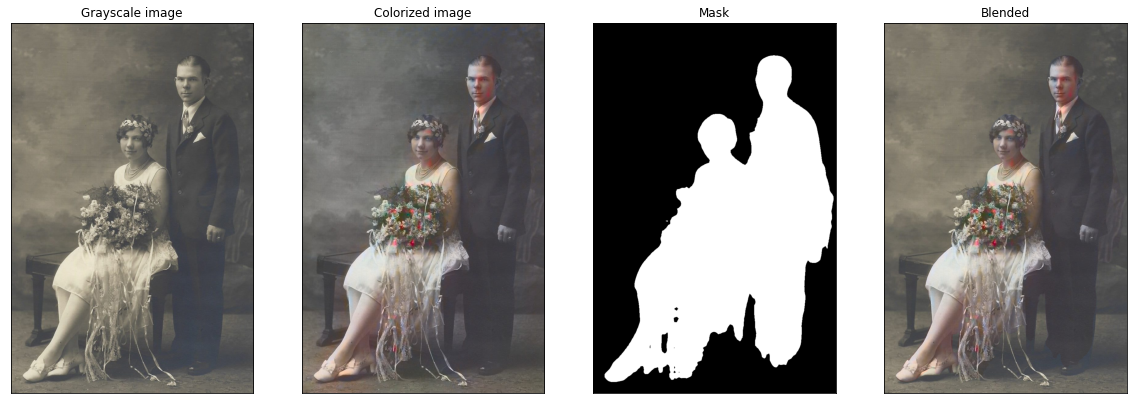

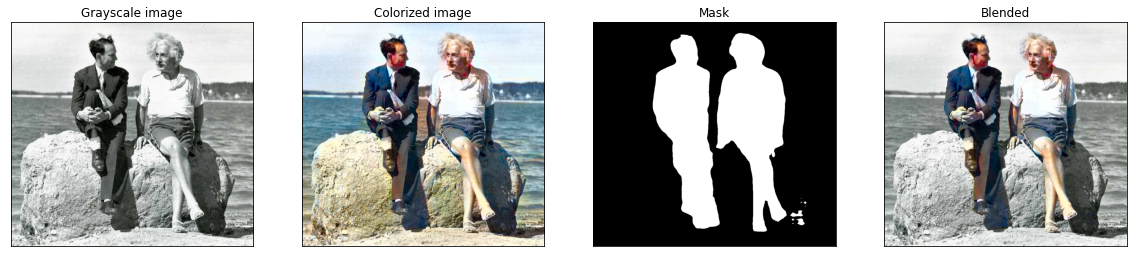

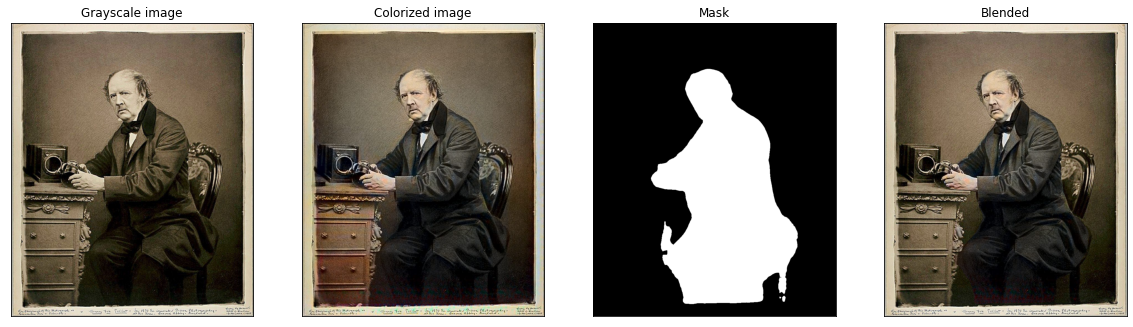

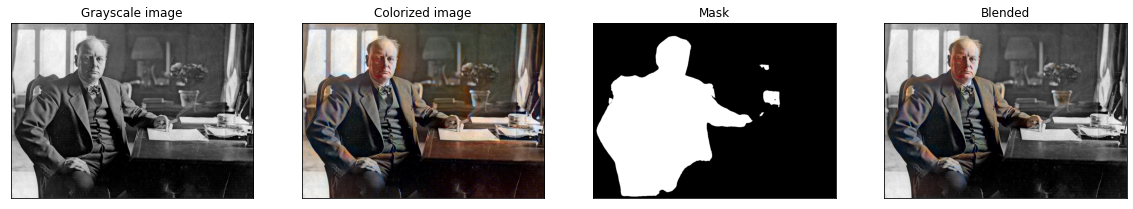

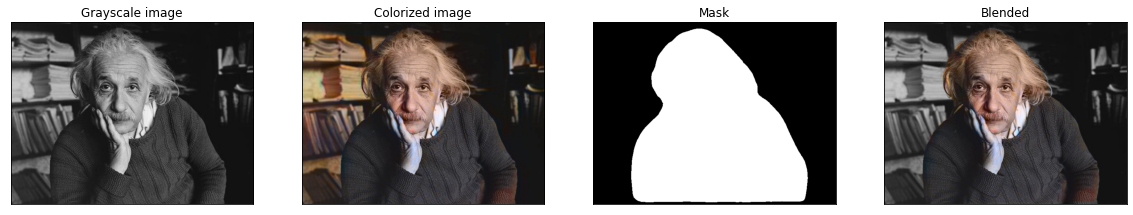

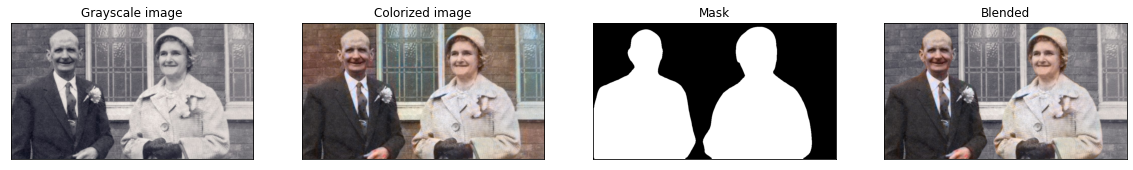

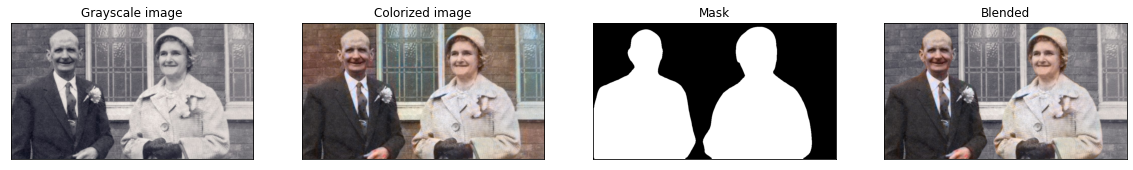

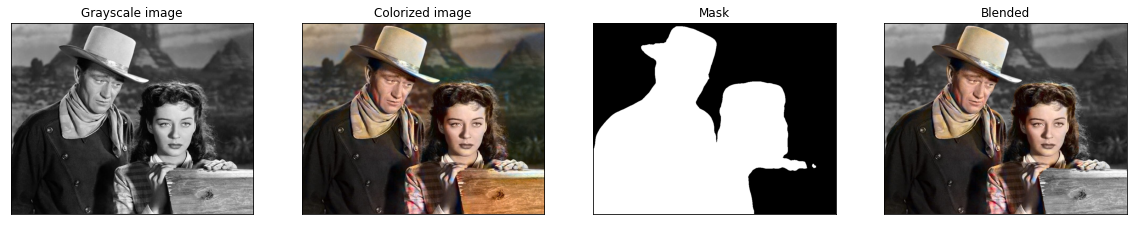

In [15]:
def show_images(im_grayscale, im_colorized, im_mask, im_blended):
    fig, axes = plt.subplots(1, 4, figsize=(20,20))
    axes[0].imshow(im_grayscale, cmap='gray')
    axes[0].set_title('Grayscale image'), axes[0].set_xticks([]), axes[0].set_yticks([])
    axes[1].imshow(im_colorized,cmap='gray')
    axes[1].set_title('Colorized image'), axes[1].set_xticks([]), axes[1].set_yticks([]);
    axes[2].imshow(im_mask * 255,cmap='gray')
    axes[2].set_title('Mask'), axes[2].set_xticks([]), axes[2].set_yticks([]);
    axes[3].imshow(im_blended ,cmap='gray')
    axes[3].set_title('Blended'), axes[3].set_xticks([]), axes[3].set_yticks([]);

for i in range(len(grayscale_images)): 
    show_images(grayscale_images[i], colorized_images[i], _masks[i], blended_images[i])

# References 

1. https://nanonets.com/blog/semantic-image-segmentation-2020/ A 2021 guide to Semantic Segmentation

2. https://towardsdatascience.com/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch-f770863d6a42 Transfer Learning for Segmentation Using DeepLabv3 in PyTorch

3. https://arxiv.org/pdf/2007.00047.pdf A Survey on Instance Segmentation: State of the art



4. https://arxiv.org/pdf/1606.00915.pdf DeepLab: Semantic Image Segmentation with Deep Convolutional Nets, Atrous Convolution, and Fully Connected CRFs



5. https://arxiv.org/pdf/1706.05587v3.pdf Rethinking Atrous Convolution for Semantic Image Segmentation



6. https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/pytorch_vision_deeplabv3_resnet101.ipynb
